# Retrieve Lego Resale Value Data Via Brick Owl API

## Background Information
Brick Owl is an online marketplace dedicated to buying and selling LEGO-related products. Founded in 2013, it serves as a platform where LEGO enthusiasts, collectors, and resellers can connect. The website offers a vast catalog of LEGO items, including sets, minifigures, parts, and accessories. Users can browse through new and used items, and sellers range from individual hobbyists to large retailers.

Read more about Brick Owl API documentation [here](https://www.brickowl.com/api/v1/docs).

## Objective
- Retrive information about lego sets along with their BOID (Brick Owl ID).
- From there we can use the BOID to get the resale value of the set.
- For each set we will perform aggregations to get the average, min and max resale values of that particular set.
- Merge two data frames together.

---
### Get Sets Information

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from currency_converter import CurrencyConverter
import time
import http.client
import json

In [2]:
my_key = '8df037e6c92401ab8e84f405b08cf590b7c8c694b01e5572c0f3eb1fe6d0d8f5'
url = 'https://api.brickowl.com/v1/catalog/list'
params = {
    'key' : my_key,
    'type': 'Set',
    'format': 'json'
}

response = requests.get(url, params=params)
response.status_code

200

Status code is 200 means the request was successful.

In [3]:
data = response.json()
len(data)

19029

There are 18,881 sets currently on the website.

In [4]:
df = pd.DataFrame(data)
df

,boid,type,name,permalink
0,168777,Set,LEGO 007 Aston Martin DB5 Set 76911,https://www.brickowl.com/boid/168777
1,348002,Set,LEGO 1-2-3 ... Marie Set 3122,https://www.brickowl.com/boid/348002
2,572590,Set,LEGO 1:87 12 Cars Set 698-2,https://www.brickowl.com/boid/572590
3,659727,Set,LEGO 1:87 6 European Cars Set 695-2,https://www.brickowl.com/boid/659727
4,645443,Set,LEGO 1:87 6 German Cars Set 696-2,https://www.brickowl.com/boid/645443
...,...,...,...,...
19024,955844,Set,LEGO Zookeeper Set 8805-7,https://www.brickowl.com/boid/955844
19025,529628,Set,LEGO Zorch Set 41502,https://www.brickowl.com/boid/529628
19026,797576,Set,LEGO Zurg Battle Set 76831,https://www.brickowl.com/boid/797576
19027,679748,Set,LEGO ZX Turbo Set 8150,https://www.brickowl.com/boid/679748


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   boid       19029 non-null  object
 1   type       19029 non-null  object
 2   name       19029 non-null  object
 3   permalink  19029 non-null  object
dtypes: object(4)
memory usage: 594.8+ KB


In [6]:
# Uncomment this for the first time running the script
#df['boid'].to_csv('boid.csv', index=False)


### Get Resale Value Information

In [7]:
availability_url = 'https://api.brickowl.com/v1/catalog/availability'
my_key = '8df037e6c92401ab8e84f405b08cf590b7c8c694b01e5572c0f3eb1fe6d0d8f5'

boids = pd.read_csv('boid2.csv')
boids = boids[boids.columns[0]].to_list()

#all_data = pd.DataFrame(columns=['boid']) --> FOR FIRST TIME RUNNING ONLY ELSE USE THE LINE BELOW THIS
all_data = pd.read_csv('brickowl_data.csv')
diff = list(set(boids) - set(all_data['boid'].unique())) # Get the boids that are not in the data
print('Number of BOIDs left: ',len(diff))

# ************* Insert the index to stop at *************

to_i = 2500  # How many iterations to do (starts small then increase as you see fit -- too large will run for a LONG time)
i = 0
for boid in diff[i,to_i]:
    success = False
    
    while not success:
        params = {
            'key': my_key,
            'boid': '{}'.format(boid),
            'country': 'US',
            'format': 'json'
        }
        
        response = requests.get(availability_url, params=params)
        
        if response.status_code == 200:
            data = response.json()
            #print(data)
            if len(data) == 0:
                #print('No data found')
                boids.remove(boid) # Remove this from boids list
                success = True # No need to retry
            else:
                df = pd.DataFrame(data).T
                all_data = pd.concat([all_data, df])
                if i % 10 == 0:
                    print(i)
                success = True  # Set success to True to exit the retry loop
            i += 1
        if i == 600:
            print('Rate Limit Pause...')
            time.sleep(61) # Sleep for 61 seconds before retrying
        
        if response.status_code != 200:
            print(f'Error: {response.status_code}')
            break

print('Job finished', i)
pd.Series(boids).to_csv('boids.csv', index=False)
all_data.to_csv('brickowl_data.csv', index=False)

Number of BOIDs left:  834


C:\Users\truon\AppData\Local\Temp\ipykernel_21948\2463339972.py:35: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  all_data = pd.concat([all_data, df])


0
20
40
110
130
160
180
200
210
220
230
250
270
280
290
300
320
330
350
360
430
440
450
460
470
490
500
520
530
550
560
570
Rate Limit Pause...
610
640
650
660
680
710
720
730
740
760
790
800
Job finished 834


In [2]:
brick_owl = pd.read_csv('brickowl_data.csv')
brick_owl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102543 entries, 0 to 102542
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   con                  102543 non-null  object 
 1   lot_id               102543 non-null  int64  
 2   price                102543 non-null  float64
 3   qty                  102543 non-null  int64  
 4   bulk_qty             102543 non-null  int64  
 5   url                  102543 non-null  object 
 6   updated              102543 non-null  int64  
 7   created              102543 non-null  int64  
 8   type                 102543 non-null  object 
 9   set_number           102242 non-null  object 
 10  boid                 102543 non-null  int64  
 11  store_id             102543 non-null  int64  
 12  store_name           102543 non-null  object 
 13  base_currency        102543 non-null  object 
 14  country              102543 non-null  object 
 15  square_logo_24   

In [3]:
brick_owl.head(2)

,con,lot_id,price,qty,bulk_qty,url,updated,created,type,set_number,...,store_name,base_currency,country,square_logo_24,square_logo_16,store_url,feedback_count,minimum_order,minimum_lot_average,open
0,new,89951153,35.0,18,1,https://3bricks.brickowl.com/store/lego-007-as...,1722346418,1659347388,Set,76911-1,...,3_BRICKS,EUR,SI,https://img.brickowl.com/files/image_cache/log...,https://img.brickowl.com/files/image_cache/log...,https://3bricks.brickowl.com,1379,10.0,0.0,True
1,new,93857489,30.0,5,1,https://ksync.brickowl.com/store/lego-007-asto...,1723303908,1663345543,Set,76911-1,...,Kitchen Sync,USD,US,https://img.brickowl.com/files/image_cache/log...,https://img.brickowl.com/files/image_cache/log...,https://ksync.brickowl.com,681,5.0,0.0,True


Now we have retrieved the dataset containning the information about sets that are currently on the market, along with its current price on Brick Owl.
However, the price is displayed acorrding to the currency of the country the seller is from. We will convert the price to NZD for better comparison.

### Currency Conversion

Using API from [FXRatesAPI](https://fxratesapi.com/docs/endpoints/latest-exchange-rates) to get the lastest exchange rate, then we will create a function to convert the price to NZD for our Brick Owl dataset.

In [3]:
currencies = brick_owl['base_currency'].unique().tolist()
my_currencies = ','.join(currencies)
base = 'USD'

fx_rate_key = 'fxr_live_93c8eb8a985575bd5fcbc0fd66f471527c31'
conn = http.client.HTTPSConnection("api.fxratesapi.com")
conn.request("GET", "/latest?base={}&currencies={}&resolution=1m&amount=1&places=6&format=json".format(base, my_currencies))

res = conn.getresponse()
data = res.read()

data = data.decode("utf-8")

In [4]:
fx_data = json.loads(data)
fx_data

{'success': True,
 'terms': 'https://fxratesapi.com/legal/terms-conditions',
 'privacy': 'https://fxratesapi.com/legal/privacy-policy',
 'timestamp': 1724237400,
 'date': '2024-08-21T10:50:00.000Z',
 'base': 'USD',
 'rates': {'AUD': 1.48322,
  'BGN': 1.75952,
  'CAD': 1.36017,
  'CHF': 0.85517,
  'CZK': 22.547354,
  'DKK': 6.706531,
  'EUR': 0.89873,
  'GBP': 0.76681,
  'HUF': 352.557371,
  'ILS': 3.72174,
  'MXN': 18.944563,
  'MYR': 4.374941,
  'NOK': 10.501501,
  'NZD': 1.62809,
  'PLN': 3.851071,
  'RON': 4.473461,
  'SEK': 10.235332,
  'SGD': 1.30705,
  'THB': 34.276214,
  'TRY': 33.926694,
  'TWD': 31.943725,
  'USD': 1}}

In [5]:
rates = fx_data['rates']

In [6]:
def convert_to_usd(price, currency, conversion_rates):
    rate  = conversion_rates[currency]
    return price * (1/rate)

convert_to_usd(100, 'NZD', rates)   

61.42166587842195

$100 NZD = $61.42 USD sounds about right.

We will use the function above to convert the prices to NZD.

In [7]:
brick_owl['price_usd'] = brick_owl.apply(lambda x: convert_to_usd(x['price'], x['base_currency'], conversion_rates=rates), axis=1)
brick_owl.head()

,con,lot_id,price,qty,bulk_qty,url,updated,created,type,set_number,...,base_currency,country,square_logo_24,square_logo_16,store_url,feedback_count,minimum_order,minimum_lot_average,open,price_usd
0,new,89951153,35.00,18,1,https://3bricks.brickowl.com/store/lego-007-as...,1722346418,1659347388,Set,76911-1,...,EUR,SI,https://img.brickowl.com/files/image_cache/log...,https://img.brickowl.com/files/image_cache/log...,https://3bricks.brickowl.com,1379,10.0,0.0,True,38.943843
1,new,93857489,30.00,5,1,https://ksync.brickowl.com/store/lego-007-asto...,1723303908,1663345543,Set,76911-1,...,USD,US,https://img.brickowl.com/files/image_cache/log...,https://img.brickowl.com/files/image_cache/log...,https://ksync.brickowl.com,681,5.0,0.0,True,30.000000
2,new,95498341,29.69,18,1,https://bommibricks.brickowl.com/store/lego-00...,1723924361,1665585164,Set,76911-1,...,USD,US,NaN,NaN,https://bommibricks.brickowl.com,565,0.0,0.0,True,29.690000
3,new,98826355,24.99,14,1,https://whitestoreman.brickowl.com/store/lego-...,1704359920,1669593921,Set,76911-1,...,EUR,ES,NaN,NaN,https://whitestoreman.brickowl.com,14,0.0,0.0,True,27.805904
4,new,99220389,40.00,3,1,https://southwestbricksuk.brickowl.com/store/l...,1698080683,1670103797,Set,76911-1,...,GBP,GB,https://img.brickowl.com/files/image_cache/log...,https://img.brickowl.com/files/image_cache/log...,https://southwestbricksuk.brickowl.com,176,0.1,0.0,True,52.164161


### Data Transformation

> - Keep only the necessary columns. 
> - Transform the shape of the data from wide to long format using aggregrations.
> - Merge the two dataframes together.

In [8]:
columns_to_keep = ['set_number', 'con', 'qty', 'price_usd']
df = brick_owl[columns_to_keep]

In [11]:
new = df[df.con == 'new'].groupby('set_number').agg({'price_usd': ['min', 'max', 'mean'], 'qty': 'sum'})
new.columns = ['min_value_new', 'max_value_new', 'mean_value_new', 'quantity_new']
new.reset_index(inplace=True)

used = df[df.con == 'used'].groupby('set_number').agg({'price_usd': ['min', 'max', 'mean'], 'qty': 'sum'})
used.columns = ['min_value_used', 'max_value_used', 'mean_value_used', 'quantity_used']
used.reset_index(inplace=True)

final = pd.merge(new, used, on='set_number', how='outer')
final

,set_number,min_value_new,max_value_new,mean_value_new,quantity_new,min_value_used,max_value_used,mean_value_used,quantity_used
0,011-1,190.479899,190.479899,190.479899,1.0,36.514912,36.514912,36.514912,1.0
1,033-2,158.735104,158.735104,158.735104,1.0,NaN,NaN,NaN,NaN
2,087-1,69.000000,69.000000,69.000000,1.0,NaN,NaN,NaN,NaN
3,10014-1,100.141311,124.308747,116.252935,3.0,64.370000,92.379293,80.675979,5.0
4,10019-1,1669.021842,1669.021842,1669.021842,1.0,445.072491,445.072491,445.072491,1.0
...,...,...,...,...,...,...,...,...,...
11926,TRUNINJAGO-4,NaN,NaN,NaN,NaN,3.282410,3.282410,3.282410,1.0
11927,WEETABIX1-1,NaN,NaN,NaN,NaN,195.615602,195.615602,195.615602,1.0
11928,WEETABIX2-1,NaN,NaN,NaN,NaN,45.643641,58.684681,52.164161,2.0
11929,WEETABIX3-1,NaN,NaN,NaN,NaN,45.643641,104.328321,74.985981,3.0


In [12]:
final.to_csv('brickowl_final_inUSD.csv', index=False)

## EDA
Now we have information about pricing for 11,931 sets, we can combine this datasets with other datasets to perform further analysis.

In [1]:
import pandas as pd
import numpy as np

In [8]:
df = pd.read_csv('brickowl_final.csv')

In [9]:
df.shape

(11931, 9)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11931 entries, 0 to 11930
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   set_number     11931 non-null  object 
 1   min_nzd_new    9131 non-null   float64
 2   max_nzd_new    9131 non-null   float64
 3   mean_nzd_new   9131 non-null   float64
 4   quantity_new   9131 non-null   float64
 5   min_nzd_used   7891 non-null   float64
 6   max_nzd_used   7891 non-null   float64
 7   mean_nzd_used  7891 non-null   float64
 8   quantity_used  7891 non-null   float64
dtypes: float64(8), object(1)
memory usage: 839.0+ KB


In [11]:
df.describe()

,min_nzd_new,max_nzd_new,mean_nzd_new,quantity_new,min_nzd_used,max_nzd_used,mean_nzd_used,quantity_used
count,9131.000000,9131.000000,9131.000000,9131.000000,7891.000000,7891.000000,7891.000000,7891.000000
mean,125.782571,178.871021,146.347167,60.009637,71.677899,104.990189,85.748270,3.876568
std,343.427551,386.008779,356.472688,187.249769,249.838589,364.250081,275.308790,4.759804
min,0.162402,0.601777,0.601777,1.000000,0.211659,0.285740,0.285740,1.000000
25%,9.455853,23.174764,14.276838,2.000000,9.035693,15.874461,12.255662,1.000000
50%,36.007769,65.635272,49.270819,8.000000,24.279098,38.261909,31.506893,2.000000
75%,114.666238,182.707395,146.117212,44.000000,68.580908,103.531269,83.497744,5.000000
max,10171.640328,10171.640328,10171.640328,3690.000000,16186.658257,16186.658257,16186.658257,78.000000


In [19]:
df.isna().sum()

set_number          0
min_nzd_new      2800
max_nzd_new      2800
mean_nzd_new     2800
quantity_new     2800
min_nzd_used     4040
max_nzd_used     4040
mean_nzd_used    4040
quantity_used    4040
dtype: int64

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette('deep')

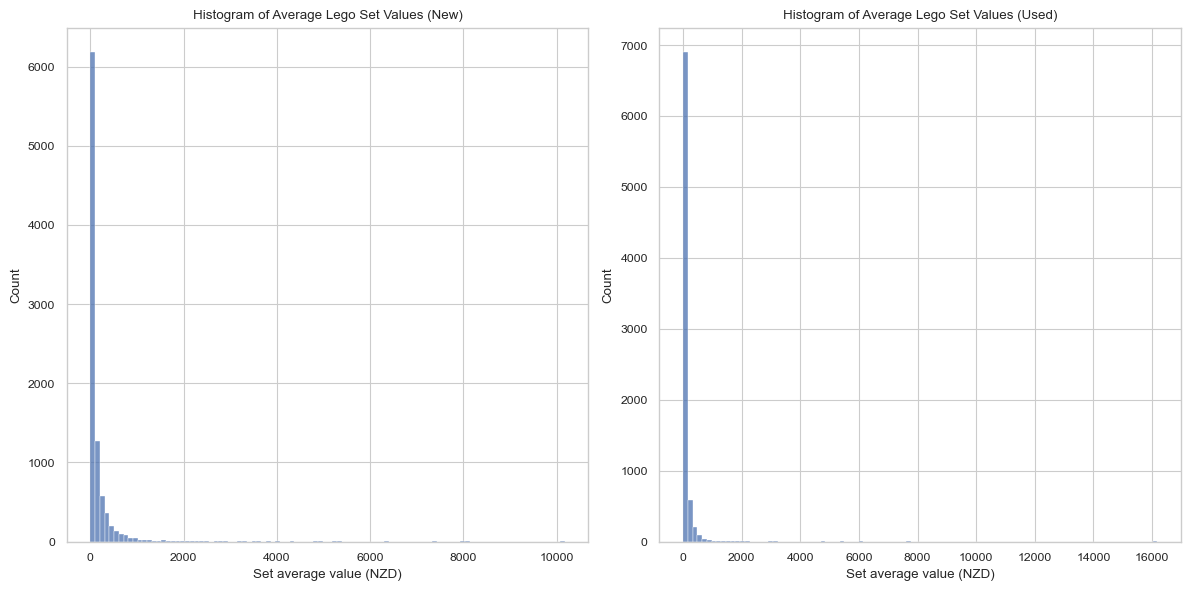

In [25]:
fig, ax = plt.subplots(1,2 ,figsize=(12, 6))

sns.histplot(df.mean_nzd_new, bins=100, ax=ax[0])
ax[0].set_title('Histogram of Average Lego Set Values (New)')
ax[0].set_xlabel('Set average value (NZD)')

sns.histplot(df.mean_nzd_used, bins=100, ax=ax[1])
ax[1].set_title('Histogram of Average Lego Set Values (Used)')
ax[1].set_xlabel('Set average value (NZD)')

plt.tight_layout()
plt.show()

In [28]:
df[df['mean_nzd_new'] > 5000]

,set_number,min_nzd_new,max_nzd_new,mean_nzd_new,quantity_new,min_nzd_used,max_nzd_used,mean_nzd_used,quantity_used
27,10143-1,8031.718896,8031.718896,8031.718896,1.0,1333.668256,2273.627866,1803.648061,2.0
38,10179-1,5240.701820,5240.701820,5240.701820,1.0,1643.268351,1643.268351,1643.268351,1.0
4866,6399-1,7408.081582,7408.081582,7408.081582,1.0,NaN,NaN,NaN,NaN
5083,6923-1,5291.486844,5291.486844,5291.486844,1.0,81.200995,108.337957,95.725694,4.0
5089,6932-1,5291.486844,5291.486844,5291.486844,1.0,117.464006,148.185362,130.650094,3.0
5098,6986-1,5291.486844,5291.486844,5291.486844,1.0,440.833380,507.982737,474.408059,2.0
5101,699-2,6349.784213,6349.784213,6349.784213,1.0,NaN,NaN,NaN,NaN
9099,COMCON018-1,10171.640328,10171.640328,10171.640328,1.0,NaN,NaN,NaN,NaN
9102,COMCON030-1,8120.083280,8120.083280,8120.083280,1.0,NaN,NaN,NaN,NaN


In [29]:
df['quantity_new'].value_counts()

1.0       1804
2.0        876
3.0        525
4.0        440
5.0        307
          ... 
1983.0       1
2210.0       1
2549.0       1
2872.0       1
477.0        1
Name: quantity_new, Length: 592, dtype: int64

In [34]:
33 + 19 + 12

64

In [33]:
df['quantity_used'].value_counts(normalize=True)

1.0     0.333925
2.0     0.195919
3.0     0.123558
4.0     0.087441
5.0     0.058421
6.0     0.048410
7.0     0.033076
8.0     0.025092
9.0     0.016728
10.0    0.015080
11.0    0.010138
12.0    0.007477
13.0    0.006590
15.0    0.006210
14.0    0.005956
18.0    0.003041
16.0    0.002535
19.0    0.002154
17.0    0.001901
20.0    0.001774
23.0    0.001774
25.0    0.001267
21.0    0.001141
22.0    0.000887
30.0    0.000887
24.0    0.000887
26.0    0.000760
40.0    0.000634
29.0    0.000634
27.0    0.000507
28.0    0.000507
32.0    0.000507
31.0    0.000507
35.0    0.000507
37.0    0.000380
51.0    0.000253
43.0    0.000253
33.0    0.000253
42.0    0.000253
44.0    0.000253
53.0    0.000253
34.0    0.000253
39.0    0.000253
78.0    0.000127
46.0    0.000127
38.0    0.000127
49.0    0.000127
56.0    0.000127
63.0    0.000127
Name: quantity_used, dtype: float64

## Getting the store locations

In [2]:
df = pd.read_csv('brickowl_data.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102543 entries, 0 to 102542
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   con                  102543 non-null  object 
 1   lot_id               102543 non-null  int64  
 2   price                102543 non-null  float64
 3   qty                  102543 non-null  int64  
 4   bulk_qty             102543 non-null  int64  
 5   url                  102543 non-null  object 
 6   updated              102543 non-null  int64  
 7   created              102543 non-null  int64  
 8   type                 102543 non-null  object 
 9   set_number           102242 non-null  object 
 10  boid                 102543 non-null  int64  
 11  store_id             102543 non-null  int64  
 12  store_name           102543 non-null  object 
 13  base_currency        102543 non-null  object 
 14  country              102543 non-null  object 
 15  square_logo_24   

In [11]:
store_locations = df[['set_number', 'country', 'store_id']]
store_locations.to_csv('store_locations.csv', index=False)